# Hillbert curve

> Spatial index for point cloud data using Hillbert space filling curve

In [ ]:
#| default_exp hillbert_curve

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
# Some functions adapted from spatialpandas at https://github.com/holoviz/spatialpandas under BSD-2-Clause license,
# Which is Initially based on https://github.com/galtay/hilbert_curve, but specialized
# for 2 dimensions with numba acceleration

# Further enhanced with numba prange.

In [ ]:
#| export
import numpy as np
from numba import prange
import math
from decorrelation.utils import ngjit, ngpjit
from decorrelation.coord import Coord

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
#| export
@ngjit
def _int_2_binary(v, width):
    """Return a binary byte array representation of `v` zero padded to `width`
    bits."""
    res = np.zeros(width, dtype=np.uint8)
    for i in range(width):
        res[width - i - 1] = v % 2
        v = v >> 1
    return res


@ngjit
def _binary_2_int(bin_vec):
    """Convert a binary byte array to an integer"""
    res = 0
    next_val = 1
    width = len(bin_vec)
    for i in range(width):
        res += next_val*bin_vec[width - i - 1]
        next_val <<= 1
    return res


@ngjit
def _hilbert_integer_to_transpose(p, h):
    """Store a hilbert integer (`h`) as its transpose (`x`).

    Args:
        p (int): iterations to use in the hilbert curve
        h (int): integer distance along hilbert curve
    Returns:
        x (list): transpose of h
                  (n components with values between 0 and 2**p-1)
    """
    h_bits = _int_2_binary(h, 2*p)

    x = [_binary_2_int(h_bits[i::2]) for i in range(2)]
    return x


@ngjit
def _transpose_to_hilbert_integer(p, coord):
    """Restore a hilbert integer (`h`) from its transpose (`x`).

    Args:
        p (int): iterations to use in the hilbert curve
        coord (list): transpose of h
                  (2 components with values between 0 and 2**p-1)

    Returns:
        h (int): integer distance along hilbert curve
    """
    bins = [_int_2_binary(v, p) for v in coord]
    concat = np.zeros(2*p, dtype=np.uint8)
    for i in range(p):
        for j in range(2):
            concat[2*i + j] = bins[j][i]

    h = _binary_2_int(concat)
    return h

In [ ]:
#| export
@ngjit
def _coordinate_from_distance(p, h):
    """Return the coordinate for a hilbert distance.

    Args:
        p (int): iterations to use in the hilbert curve
        h (int): integer distance along hilbert curve
    Returns:
        coord (list): Coordinate as length-n list
    """
    coord = _hilbert_integer_to_transpose(p, h)
    Z = 2 << (p-1)

    # Gray decode by H ^ (H/2)
    t = coord[1] >> 1
    for i in range(1, 0, -1):
        coord[i] ^= coord[i-1]
    coord[0] ^= t

    # Undo excess work
    Q = 2
    while Q != Z:
        P = Q - 1
        for i in range(1, -1, -1):
            if coord[i] & Q:
                # invert
                coord[0] ^= P
            else:
                # exchange
                t = (coord[0] ^ coord[i]) & P
                coord[0] ^= t
                coord[i] ^= t
        Q <<= 1

    return coord

In [ ]:
#| export
@ngjit
def _distance_from_coordinate(p, coord):
    """Return the hilbert distance for a given coordinate.

    Args:
        p (int): iterations to use in the hilbert curve
        coords (ndarray): coordinate as 1d array
    Returns:
        h (int): distance
    """
    M = 1 << (p - 1)
    # Inverse undo excess work
    Q = M
    while Q > 1:
        P = Q - 1
        for i in range(2):
            if coord[i] & Q:
                coord[0] ^= P
            else:
                t = (coord[0] ^ coord[i]) & P
                coord[0] ^= t
                coord[i] ^= t
        Q >>= 1
    # Gray encode
    for i in range(1, 2):
        coord[i] ^= coord[i - 1]
    t = 0
    Q = M
    while Q > 1:
        if coord[1] & Q:
            t ^= Q - 1
        Q >>= 1
    for i in range(2):
        coord[i] ^= t
    h = _transpose_to_hilbert_integer(p, coord)
    return h

In [ ]:
#| export
@ngpjit
def _coordinates_from_distances(p, h):
    """Return the coordinates for an array of hilbert distances.

    Args:
        p (int): iterations to use in the hilbert curve
        h (ndarray): 1d array of integer distances along hilbert curve
    Returns:
        coords (list): 2d array of coordinate, each row a coordinate corresponding to
            associated distance value in input.
    """
    result = np.zeros(2, (len(h)), dtype=np.int64)

    for i in prange(len(h)):
        result[:, i] = _coordinate_from_distance(p, h[i])

    return result

In [ ]:
#| export
@ngpjit
def _distances_from_coordinates(p, coords):
    """Return the hilbert distances for a given set of coordinates.

    Args:
        p (int): iterations to use in the hilbert curve
        coords (ndarray): 2d array of coordinates, one coordinate per row
    Returns:
        h (ndarray): 1d array of distances
    """
    coords = np.atleast_2d(coords).copy()
    result = np.zeros(coords.shape[1], dtype=np.int64)
    for i in prange(coords.shape[1]):
        coord = coords[:, i]
        result[i] = _distance_from_coordinate(p, coord)
    return result

In [ ]:
#| export
def hix(x:np.array, # horizonal coordinate
        y:np.array, # vertical coordinate
        bbox:list, # [x0, y0, xm, ym]
        interval:list # [x_interval, y_interval], cell size to make every cell has only one point falled in.
       )->np.array:
    '''Compute the hillbert index.'''
    x0, y0, xm, ym = bbox
    dx, dy = interval
    nx = math.ceil((xm-x0)/dx)
    ny = math.ceil((ym-y0)/dy)
    coord = Coord(x0,dx,nx,y0,dy,ny)
    idx = coord.coords2idxs([y,x])
    hix = _distances_from_coordinates(coord.p,idx)
    return hix

usage:

In [ ]:
x = np.random.rand(1000)
y = np.random.rand(1000)
bbox = [0,0,1,1]

In [ ]:
h_idx = hix(x, y, bbox, interval=[0.001,0.001])

NameError: name 'hix' is not defined

<matplotlib.colorbar.Colorbar>

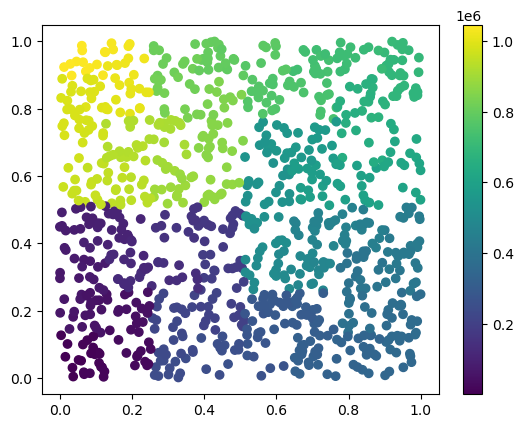

In [ ]:
plt.scatter(x, y, c=h_idx)
plt.colorbar()

Hillbert index have a very useful locality property:

- Points with hillbert indexes close to an index will be geometrically close to the point corresponding to that index.

This enable fast data query of billions of points.
See [rtree](./rtree.ipynb) for data query.

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()